# Job Posting Crawler

This is code that will pull each job posting for a specific job title in a specific location (or Nationally) and return / plot the percentage of the postings that have certain keywords.  The code is set up to search for all words except stopwords, and other user-defined words (there is probably a much more efficient way of doing this, but I had no need to change this once I had the code running).  This allows the user to see common technical skills, as well as common soft skills that should be included on a resume.  

NOTE:  I got this idea from https://jessesw.com/Data-Science-Skills/.  Obviously, just using his code would be of no real benefit to me, as I wanted to use the idea to help better my skills with scraping data from HTML files.  So, I used his idea and developed my own code from scratch.  I also modified the overall process a bit to better fit my needs.

NOTE2:  This code will not be able to identify multiple-word skills.  So, for example, 'machine learning' will show up as either 'machine' or 'learning'.  However, 'machine' could show up for other phrases than 'machine learning'.

To run the code, change the city, state, and job title to whichever you wish.  After generating the plot, you might need to add 'keywords' to the attitional_stop_words list if you do not want them to be included.

In [45]:
from bs4 import BeautifulSoup
import urllib
import re
from time import sleep
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['figure.figsize'] = (10.0, 8.0)

from wordcloud import WordCloud
import os

Define the city, state, and job title.

In [2]:
city = 'Seattle'
state = 'WA'
job_title = 'Data Scientist'

Define a function that will take the url and pull out the text of the main body as a list of strings.  Remove common words such as 'the', 'or', 'and', etc.

In [3]:
def clean_the_html(url):
    # First try to download the html file
    try:
        html = urllib.urlopen(url)
    except:
        return
    
    #print url
    
    # Open html in BeautifulSoup
    soup = BeautifulSoup(html)
        
    # Extract everything within the <p> tags
    text = soup.findAll('body')
    word_list = ''
    for line in text:
        word_list = ' '.join([word_list,line.get_text(' ',strip=True).lower()])
    
    # Remove non text characters from list
    word_list = re.sub('[^a-zA-Z+3]',' ', word_list)

    list_of_words = word_list.encode('ascii','ignore').split()
                   
    stop_words = set(stopwords.words("english"))
    additional_stop_words = ['webfont','limited','saved','disability',\
                             'desirable','nreum','skills','net','+','k',\
                            'above','it','end','excellent','join','want',\
                            'how','well','sets','like','page','home','demonstrated',\
                            'other','re','size','etc','gettime','work','ms',\
                            'zqdxyrmad','description','value','re','transactionname',\
                            'education','daylight','highly','bodyrendered',\
                            'amazon','new','bam','techniques','com',city.lower(),\
                            state.lower(),'min','need','email','job','content','features',\
                            'service','wa','id','modern','looking','eastern',\
                            'qualifications','teams','based','false','times',\
                            'software','career','ability','platform','years','data',\
                            'date','product','team','time','agent','information',\
                            'methods','candidate','customers','back','info','scientist',\
                            'experience','apply','us','engineering','learning',\
                            'strong','business','design','title','large','e','document',\
                            'science','company','location','field','communication',\
                            'customer','tools','used','research','model',\
                            'opportunity','online','including','degree',\
                            'preferred','across','beacon','using','friend','function',\
                            'position','window','role','3','written','build',\
                            'presentation','getelementbyid','technical','posted',\
                            'newrelic','decision','log','errorbeacon','solutions',\
                            'applicationtime','enable','responsibilities',\
                            'models','applicationid','complex','licensekey',\
                            'high','browser','d','nr','develop','please',\
                            'selection','queuetime','cookies','icimsaddonload',\
                            'computer','icims','scientists','great','returning',\
                            'systems','writing','united','working','iframe',\
                            'analyses','applications','try','related',\
                            'states','languages','yghvbe','language','one',\
                            'site','llc,','category','personalized','knowledge']
    
    # Remove words from list
    truncated_list = [w for w in list_of_words if not (w in stop_words or \
                      w in additional_stop_words)]
    
    truncated_set = set(truncated_list)
    truncated_list = list(truncated_set)
        
    return truncated_list

Define a function to generate a list of urls for a given search (i.e., 'Data Scientist').  Each search result page has 10 non-sponsored links.  Search the first url for 'Jobs # to # of ###' in order to determine how many iterations to perform.

In [4]:
def gen_url_list(city,state,job_name):
    base_url = 'http://www.indeed.com/'
    
    job_term = re.sub(' ','+',job_name.lower())
    
    search_url = ''.join([base_url,'jobs?q=',job_term,'&l=',city,'%2C+',state])
    
    try:
        html = urllib.urlopen(search_url)
    except:
        return
    
    soup = BeautifulSoup(html)
    
    total_jobs = soup.find(id = 'searchCount').string.encode('utf-8')
    job_nums = int([int(s) for s in total_jobs.split() if s.isdigit()][-1]/10)
    print total_jobs

    job_URLS = []
    for i in range(job_nums+1):
        if i % 10 == 0:
            print i
        if i >= 2:
            break
        page_url = ''.join([base_url,job_term,'&1=',city,'%2C+',state,\
                            '&start=',str((i+1)*10)])
        html = urllib.urlopen(search_url)
        
        soup = BeautifulSoup(html)
        
        job_link_area = soup.findAll('h2',{'class':'jobtitle'})

        for link in job_link_area:
            match_href = re.search('<a\shref="(.+?)"',str(link))
            if match_href:
                job_URLS.append([base_url + match_href.group(1)])

    return job_URLS

Now that we have a list of all of the URLs of job postings, pull the information from each site, clean the data, and populate the keyword list.

In [5]:
def job_posting_analysis(url_list):
    job_skills = []
    count = 0
    for url in url_list:
        count += 1
        if count % 10 == 1:
            print count
        
        posting_keywords = clean_the_html(url[0])
        if posting_keywords:
            job_skills.append(posting_keywords)
        sleep(0.5)
        
    return job_skills

Now that the various functions are defined, run the code.  
    First: run gen_url_list for the specified city, state, and jobtitle in order to generate
    the list of job posting links
    
Second: run job_posting_analysis to pull out the job_skills listed for each job posting.

In [6]:
print 'Crawl indeed.com for ' + city + ', ' + state + ' ' + job_title + \
' postings and generate a list of all of the job posting links'

url_list = gen_url_list(city,state,job_title)

print "Given the job posting links, pull out the keywords for each posting"

job_skills = job_posting_analysis(url_list)

Crawl indeed.com for Seattle, WA Data Scientist postings and generate a list of all of the job posting links
Jobs 1 to 10 of 713
0
Given the job posting links, pull out the keywords for each posting
1
11


Now that we have the list of keywords in the job postings, calculate the number of postings in which each keyword appears.  Then plot the data on a bar graph

In [50]:
skill_frequency = Counter() # This will create a full counter of our terms.
[skill_frequency.update(item) for item in job_skills] # List comp
#print skill_frequency.items()

most_common = skill_frequency.most_common(50)
#print most_common

[('addedtojobcart', 2), ('applicationstatusdetail', 2), ('aug', 2), ('segments', 2), ('matlab', 12), ('efccid', 2), ('stoppropagation', 2), ('merchant', 2), ('collaborate', 4), ('indeedblue', 2), ('every', 2), ('updates', 2), ('affect', 2), ('vast', 2), ('skillz', 2), ('companies', 6), ('upload', 2), ('linkid', 2), ('enhance', 4), ('heading', 2), ('cmp', 2), ('leaders', 4), ('direct', 2), ('even', 2), ('hide', 2), ('selected', 4), ('nea', 2), ('blur', 2), ('supplies', 2), ('increasing', 4), ('centric', 2), ('men', 2), ('createde', 2), ('refinement', 2), ('active', 2), ('path', 2), ('interpret', 4), ('employees', 4), ('economics', 4), ('approaches', 6), ('reports', 2), ('mentor', 2), ('military', 2), ('classification', 6), ('mobility', 2), ('julia', 2), ('visible', 4), ('unix', 2), ('thursday', 2), ('forums', 2), ('experimentation', 4), ('would', 2), ('mycart', 2), ('browse', 2), ('call', 2), ('garch', 2), ('recommend', 2), ('type', 2), ('tell', 4), ('arma', 2), ('successful', 4), ('sel

In [8]:
data_to_plot = pd.DataFrame(skill_frequency.items(),columns = ['Skill','Occurances'])

data_to_plot.Occurances = (data_to_plot.Occurances)*100/len(job_skills)

data_to_plot.sort(columns = 'Occurances',ascending = False,inplace = True)

test_data = data_to_plot.head(15)  # plot only top 15 skills

In [9]:
print data_to_plot.head(20)

            Skill  Occurances
726            js          80
1270     analysis          80
654             r          80
1549       python          70
87        machine          70
241     analytics          60
1808       create          60
1697     modeling          60
817         world          60
1348   statistics          60
436           sql          60
350      advanced          60
4          matlab          60
213            d3          50
810          real          50
74      scripting          50
480       current          50
569   statistical          50
1295     projects          50
772    technology          50


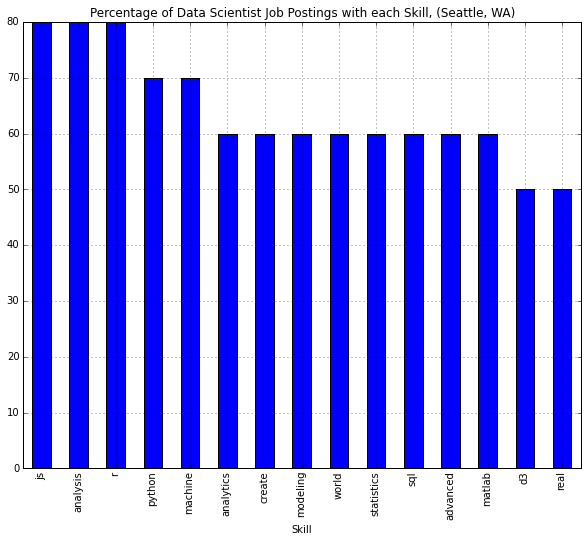

In [10]:
frame = test_data.plot(x='Skill',kind='bar',legend=None,\
                  title='Percentage of Data Scientist Job Postings with each Skill, ('\
                  + city + ', ' + state + ')')

#plt.ylim([40,90])

fig = frame.get_figure()

In [175]:
filename = '_'.join([city,state,'skills'])
filename = ''.join([filename,'.pdf'])
pp = PdfPages(filename)
pp.savefig(fig)
pp.close()

alpha alpha alpha bravo bravo bravo bravo bravo bravo bravo bravo bravo charlie charlie delta bravo bravo bravo bravo bravo bravo bravo bravo bravo bravo bravo bravo bravo bravo bravo bravo


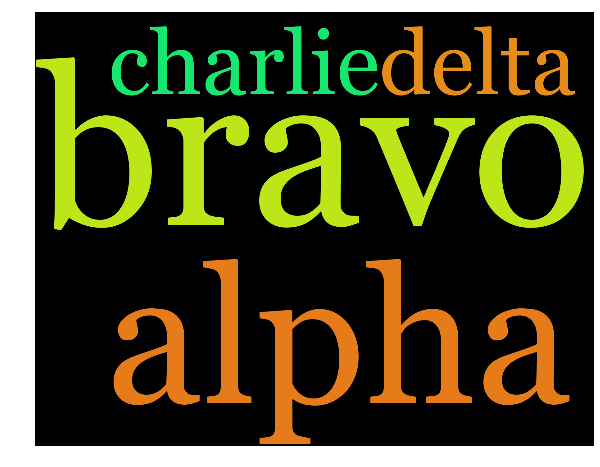

In [69]:
dct = dict(most_common)
word_list = dct.keys()
print word_list
print job_skills[0]
wordcloud_words = ' '.join(job_skills[0])
print wordcloud_words
wordcloud = WordCloud(font_path='/Library/Fonts/Georgia.ttf',
                      background_color='black',
                      width=1800,
                      height=1400).generate(wordcloud_words)
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('./my_twitter_wordcloud_1.png', dpi=300)
plt.show()